In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

2023-02-05 19:14:09.396465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 19:14:09.592089: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-05 19:14:09.596573: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 19:14:09.596595: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [10]:
SIZE = 32

class Generator(tf.keras.Sequential):
    def __init__(self, input_dim=100, *args, **kwargs):
        super(Generator, self).__init__(*args, **kwargs)
        self.add(tf.keras.layers.Dense(SIZE//4*SIZE//4*256, use_bias=False, input_shape=(input_dim,)))
        self.add(tf.keras.layers.BatchNormalization())
        self.add(tf.keras.layers.LeakyReLU())

        self.add(tf.keras.layers.Reshape((SIZE//4, SIZE//4, 256)))
        assert self.output_shape == (None, SIZE//4, SIZE//4, 256)  # Note: None is the batch size

        self.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        assert self.output_shape == (None, SIZE//4, SIZE//4, 128)
        self.add(tf.keras.layers.BatchNormalization())
        self.add(tf.keras.layers.LeakyReLU())

        self.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert self.output_shape == (None, SIZE//2, SIZE//2, 64)
        self.add(tf.keras.layers.BatchNormalization())
        self.add(tf.keras.layers.LeakyReLU())

        self.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        assert self.output_shape == (None, SIZE, SIZE, 1)
    
    def generator_loss(self, fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        return cross_entropy(tf.ones_like(fake_output), fake_output)


Model: "generator_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_9 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 128)        

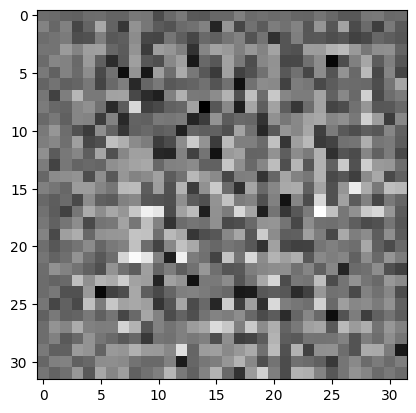

In [11]:
generator = Generator()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
print(generated_image.shape)

In [ ]:
vgg19 = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

In [14]:
input_layer = tf.keras.layers.InputLayer((28, 28, 3))
conv2D_layer = tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(8, 8), padding='same', use_bias=False)

model = tf.keras.Sequential()
model.add(input_layer)
model.add(conv2D_layer)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_12 (Conv2D  (None, 224, 224, 3)      225       
 Transpose)                                                      
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# add layers from vgg19 to model, except the last three
for layer in vgg19.layers[1:-3]:
    model.add(layer)